For the **Support Vector Machine** example we have decided to go forward with a bullish/bearish regime classifier. We have chosen **AMZN** as our asset of interest, and are going to look at the prices of our asset for the last 5 years. Then we are going to calculate short-term and long-term moving averages of daily returns and define the regimes:

if $\text{MA}_{20} \ge \text{MA}_{200} \rightarrow \text{Bullish Regime}$

else $\text{MA}_{20} \lt \text{MA}_{200} \rightarrow \text{Bearish Regime}$

After we download and clean our dataset, we plot the moving average values with respective regimes:

[*********************100%***********************]  1 of 1 completed

                20ma     200ma  bullish
Date                                   
2020-10-20  0.001676  0.002947        0
2020-10-21  0.003241  0.002886        1
2020-10-22  0.002774  0.002912        0
2020-10-23  0.001968  0.002932        0
2020-10-26  0.000734  0.002983        0


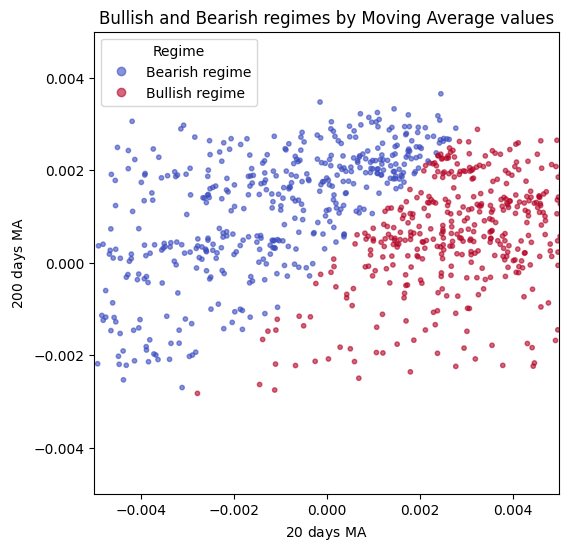

In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
import sklearn.model_selection as skm
from ISLP import confusion_table
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay
import yfinance as yf
import datetime as dt

def gen_asset_data(ticker, start, end):
    df = yf.download(ticker, start, end).loc[:, ["Adj Close", "Volume"]]
    df.columns = ["price", "volume"]
    df["returns"] = df.loc[:, "price"].pct_change()
    df["20ma"] = df["returns"].rolling(20).mean()
    df["200ma"] = df["returns"].rolling(200).mean()
    df["bullish"] = (df["20ma"] > df["200ma"]).astype(int)
    df = df.dropna()
    df = df.loc[:, ["20ma", "200ma", "bullish"]]
    return df

# Params
n_days = 365*5
end = dt.datetime.today()
start = end - dt.timedelta(n_days)
ticker = "AMZN"

# Generate dataframe
df = gen_asset_data(ticker, start, end)
print(df.head())

# Plot the features and labels
fig, ax = plt.subplots(figsize=(6, 6))
scatter = ax.scatter(df.iloc[:, 0], df.iloc[:, 1], c=df.iloc[:, 2], cmap=cm.coolwarm, s=10, alpha=0.6)
ax.set_title("Bullish and Bearish regimes by Moving Average values")
ax.set_xlabel("$20$ days MA")
ax.set_ylabel("$200$ days MA")

ax.set_xlim((-0.005, 0.005))
ax.set_ylim((-0.005, 0.005))

handles, _ = scatter.legend_elements(prop="colors")
labels = ["Bearish regime", "Bullish regime"]
ax.legend(handles, labels, title="Regime", loc="upper left")

We use $\text{MA}_{20}$ and $\text{MA}_{200}$ as our **features** $X_1$ and $X_2$.

We use regimes with binary numbers (Bullish:$1$, Bearish:$0$) as our **labels**.

We choose a linear kernel for the **SVM** algorithm (polynomial of degree 1) and select the regularization parameter as $C=0.5$ and train our **SVM** algorithm.

Linear SVM Confusion Table:
Truth        0    1
Predicted          
0          104    0
1            4  104


C:\Users\adevr\AppData\Local\Temp\ipykernel_14132\555730460.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()


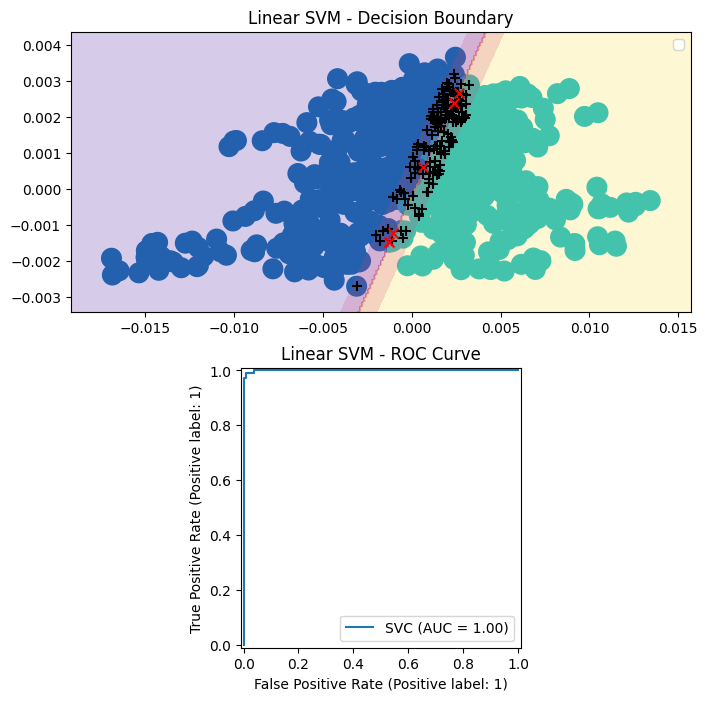

In [ ]:
# Split features and labels data
X = df.iloc[:, 0:2].to_numpy()
y = df.iloc[:, 2].to_numpy()

# Split data into training and test sets
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.2)

# Use SVC class from sklearn library to fit SVM with different choice of kernel functions
svm_poly = SVC(kernel='poly', degree=1, C=0.5, gamma='scale', probability=True)
svm_poly.fit(X_train, y_train)

# Get class predictions for test datasets
y_hat = svm_poly.predict(X_test)

# Print confusion tables to show accuracy
print("Linear SVM Confusion Table:")
print(confusion_table(y_test, y_hat))

# Plotting decision boundaries and performance curves
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

axes[0].set_title("Linear SVM - Decision Boundary")
plot_svm(X_train, y_train, svm_poly, ax=axes[0])
# axes[0, 0].scatter(X_test_rad[:, 0], X_test_rad[:, 1], c=y_test_rad, marker='x', cmap='coolwarm', alpha=0.7)

axes[1].set_title("Linear SVM - ROC Curve")
RocCurveDisplay.from_estimator(svm_poly, X_test, y_test, ax=axes[1])

When we look at the results we see that an **SVM** algorithm with a linear kernel function is able to perfectly classify the bullish and bearish regimes. This is expected because by construction the algorithm has access to full information on the features (moving average values). This is also reflected in the **ROC** curve, as even at $0$ **FPR** it has a ratio of $1$ **TPR**.